# Brunel Network

This is simulation of Brunel Network based on the following paper:

*Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons
NICOLAS BRUNEL, Journal of Computational Neuroscience 8, 183–208 (2000)*

The simulation is done by NEST : https://www.nest-simulator.org/

The main aim is to have large spiking network of leaky-integrate and fire neurons (inhibitory and excitatory) as a ground truth. 
In next step, I will try to estimate the connectivity of this network by fitting an Auto-regressive process and measure how well this method can infere based on ground truth.

This simulation process has been run on the computing nodes of Bernstein Center Freiburg (https://www.bcf.uni-freiburg.de). So, it has benefited multiple threading.

In [15]:
#%matplotlib qt

import nest
import nest.raster_plot

import matplotlib.pyplot as plt
import numpy as np

import time
from numpy import exp

import csv

nest.ResetKernel()

In [3]:
startbuild = time.time()
nest.SetKernelStatus({"local_num_threads": 32})

----> the problem of 0.1ms resolusion should be solved. spike times in this case is given as x.y. so it need to get multiplied by 10!

In [4]:
dt = 0.1  # the resolution in ms
simtime = 500.0 # Simulation time in ms
#spike_bin = 10 #bin size for downsampling the spike train  (after checking whole code this line shall be removed.)
delay = 1.5  # synaptic delay in ms

In [5]:
g = 6.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

In [6]:
order = 250
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

In [7]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

In [8]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 8.  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

In [9]:
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 10000.0 * nu_ex * CE
p_rate

2500.0

In [10]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

Building network

Mar 09 21:54:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


DC generator was for testing something!

In [11]:
nest.SetDefaults("iaf_psc_delta", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

#DC generator
nest.SetDefaults("dc_generator", {"amplitude": 6.})

In [12]:
nodes_ex = nest.Create("iaf_psc_delta", NE)
nodes_in = nest.Create("iaf_psc_delta", NI)

#DC Generator
noise = nest.Create("poisson_generator")
#noise = nest.Create("dc_generator")

espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

In [13]:
#neuron test
neuron_test = nest.Create("iaf_psc_delta", 1)

In [14]:
#neuron test multimeter
multimeter_neuron = nest.Create("multimeter")
nest.SetStatus(multimeter_neuron, {"withtime":True, "record_from":["V_m"]})

multimeter_network_E = nest.Create("multimeter")
nest.SetStatus(multimeter_network_E, {"withtime":True, "record_from":["V_m"]})

multimeter_network_I = nest.Create("multimeter")
nest.SetStatus(multimeter_network_I, {"withtime":True, "record_from":["V_m"]})

NESTErrors.DictError: DictError in SLI function SetStatus_id: Unused dictionary items:  withtime

In [26]:
#spike detectors
sp_detector = nest.Create("spike_detector", 1)

In [27]:
nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

print("Connecting devices")

Connecting devices

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 
    Data will be recorded to file and to memory.

Feb 06 10:16:54 RecordingDevice::set_status [Info]: 


In [28]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

In [29]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

#neuron test noise
nest.Connect(noise, neuron_test, syn_spec="excitatory")

In [30]:
#connecting multimeters
nest.Connect(multimeter_neuron, neuron_test)
nest.Connect(multimeter_network_E, [nodes_ex[100]])
nest.Connect(multimeter_network_I, [nodes_in[120]])

In [31]:
#connect spike detector
nest.Connect(nodes_ex + nodes_in, sp_detector, syn_spec="excitatory")

In [32]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


In [33]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


In [34]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

In [35]:
endbuild = time.time()

In [36]:
print("Simulating")

nest.Simulate(simtime)

Simulating

Feb 06 10:16:57 NodeManager::prepare_nodes [Info]: 
    Preparing 1475 nodes for simulation.

Feb 06 10:16:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1475
    Simulation time (ms): 500
    Number of OpenMP threads: 32
    Not using MPI

100 %: network time: 500.0 ms, realtime factor: 0.5945

Feb 06 10:16:58 SimulationManager::run [Info]: 
    Simulation finished.


In [37]:
endsimulate = time.time()

In [38]:
events_ex = nest.GetStatus(espikes, "n_events")[0]
events_in = nest.GetStatus(ispikes, "n_events")[0]

In [39]:
rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

In [40]:
num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

In [41]:
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

In [42]:
print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory rate   : %.2f Hz" % rate_ex)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

Brunel network simulation (Python)
Number of neurons : 1250
Number of synapses: 158851
       Exitatory  : 126250
       Inhibitory : 31250
Excitatory rate   : 121.28 Hz
Inhibitory rate   : 115.00 Hz
Building time     : 3.74 s
Simulation time   : 1.48 s


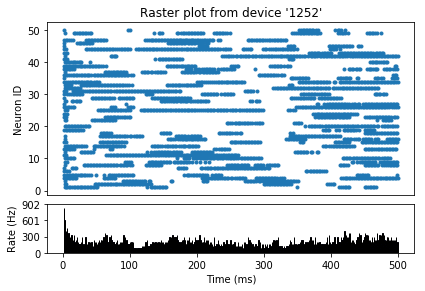

In [157]:
nest.raster_plot.from_device(espikes, hist=True, hist_binwidth=0.5)

Following blocks are for testig the whole process. signals and ...

In [43]:
#reading spike detector
sp_detector_data = nest.GetStatus(sp_detector, "events")[0]
sp_times = sp_detector_data["times"]
sp_senders = sp_detector_data["senders"]

In [44]:
np.save("sp_times-60e6-ms", sp_times)
np.save("sp_senders-60e6-ms", sp_senders)

This block may get improved as submatrix selection which had done for problem of hidden nodes.

In [45]:
#Get Connectivity matrix
conn_tuple = nest.GetConnections(source= nodes_ex+nodes_in, target=nodes_ex+nodes_in)

conn_matrix = np.zeros((N_neurons, N_neurons))

sources = nest.GetStatus(conn_tuple, 'source')
targets = nest.GetStatus(conn_tuple, 'target')
weights = nest.GetStatus(conn_tuple, 'weight')

counter = 0

for i, j in zip(sources, targets):
    conn_matrix[j-1, i-1] = weights[counter]
    counter+=1
    
np.save("connectivity-60e6-ms", conn_matrix)

In [47]:
spikes = np.histogram2d(sp_senders, sp_times, bins=[range(1, 1252), np.arange(0, simtime+1, 1)])[0]

np.save("spikes-60e6-ms", spikes)
np.shape(spikes)

(1250, 5000)

This codes has been left here to be used later.

In [ ]:
with open("runs_variable.csv", "w+") as csvfile:
    fieldnames = ["sim_time", "order", "eta", "epsilon", "g", "j", "p_rate", "rate_ex", "rate_in", "num_syn"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

In [ ]:
#writing multiple runs variables into a csv, it should be merged with the correlation results in the var nb.
fieldnames = ["sim_time", "order", "eta", "epsilon", "g", "j", "p_rate", "rate_ex", "rate_in", "num_syn"]
variable_dict = {"sim_time": simtime, "order": order, "eta": eta, "epsilon": epsilon, "g": g, "j": J,
                 "p_rate": p_rate, "rate_ex": rate_ex, "rate_in": rate_in, "num_syn": num_synapses}

with open("runs_variable.csv", "a") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerow(variable_dict)